# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1123]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "drive/MyDrive/Dataset/images.zip" -d "."
!cp "drive/MyDrive/Dataset/annotations.json" -d "."

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [672]:
from torchvision.transforms import InterpolationMode
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [742]:

# Ścieżka do obrazu
img_path = 'images/0/G000_IMG000.jpg'
img = Image.open(img_path).convert('RGB').convert('RGB')

# Funkcja do wyświetlania obrazu torch.Tensor
def show_tensor_image(tensor, title=''):
    if isinstance(tensor, torch.Tensor):
        # Zakładamy [C, H, W]
        tensor = tensor.clone().detach()
        tensor = tensor.permute(1, 2, 0)  # -> [H, W, C]
        tensor = tensor.clamp(0, 1)  # do zakresu [0,1]
        plt.imshow(tensor.numpy())
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        # Dla obrazu PIL
        plt.imshow(tensor)
        plt.title(title)
        plt.axis('off')
        plt.show()


In [15]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1

        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]
        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1)
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = cv2.imread(os.path.join(self.root, self.file_names[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        num_pieces = self.num_pieces[i].item()

        return image, num_pieces

train_dataset = ChessDataset('', 'train', data_aug)
valid_dataset = ChessDataset('', 'valid', data_in)
test_dataset = ChessDataset('', 'test', data_in)

Number of train images: 1442
Number of valid images: 330
Number of test images: 306


In [20]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

Using cpu device


torch.Size([16, 224, 224, 3])
torch.Size([16])
tensor(22., dtype=torch.float64)


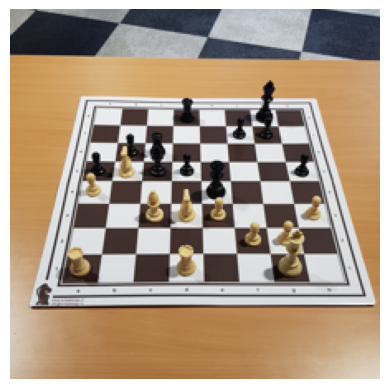

In [26]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels.shape)
    print(labels[0])

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

In [78]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
model1 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
num_classes = 32
model1.fc = nn.Linear(model1.fc.in_features, 32)

model1.to(device)

Using cpu device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train the model

Define function to perform one iteration

In [82]:
from tqdm import tqdm
def train_classifier(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, num_epochs=50, lr_scheduler=None):
    
    model = model.to(device)
    
    # Evaluation history
    train_history = {
        'loss': [],
        'acc': [],
    }
    val_history = {
        'loss': [],
        'acc': [],
    }
    for epoch in range(num_epochs):
        # Training 
        model.train()
        epoch_train_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.argmax(dim=1))
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            _, predicted = outputs.max(1)
            _, labels_idx = labels.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels_idx).sum().item()
        
        train_loss = epoch_train_loss / len(train_dataloader)
        train_acc = 100. * correct / total
        train_history['loss'].append(train_loss)
        train_history['acc'].append(train_acc)
        
        # Validation 
        val_loss, val_acc = evaluate_classifier(model, val_dataloader, loss_fn, device)
        val_history['loss'].append(val_loss)
        val_history['acc'].append(val_acc)
        
        # # Update learning rate if scheduler provided
        # if lr_scheduler:
        #     if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        #         lr_scheduler.step(val_loss)
        #     else:
        #         lr_scheduler.step()
        
        print(f'Train Loss: {train_loss:.4f} || Train Acc: {train_acc:.2f}')
        print(f'Val Loss: {val_loss:.4f} || Val Acc: {val_acc:.2f}')
    
    return train_history, val_history

def evaluate_classifier(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.argmax(dim=1))
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            _, labels_idx = labels.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels_idx).sum().item()
    
    loss = running_loss / len(dataloader)
    acc = 100. * correct / total
    return loss, acc

Define loss, optimizer and train the model

In [80]:
import torch.optim as optim

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optimizer_phase1 = optim.Adam(model1.fc.parameters(), lr=0.001)
optimizer_phase2 = optim.Adam(model1.fc.parameters(), lr=0.0001)

## Analyse training evolution

In [ ]:
# 1 Phase: train with frozen layers
for name, param in model1.named_parameters():
    if not name.startswith('fc'):
        param.requires_grad = False

train_history_phase1, val_history_phase1 = train_classifier(
    model1, train_dataloader, valid_dataloader, loss_fn, optimizer_phase1, device, num_epochs=10
)

In [ ]:
# 2nd Phase: train whole model (unfreeze)
for param in model1.parameters():
    param.requires_grad = True
    
train_history_phase2, val_history_phase2 = train_classifier(
    model1, train_dataloader, valid_dataloader, loss_fn, optimizer_phase2, device, num_epochs=40
)

Plot loss and accuracy throughout training on train and validation data

In [ ]:
train_history = train_history_phase1.extend(train_history_phase2)
val_history = val_history_phase1.extend(val_history_phase2)

In [93]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

In [ ]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [2]:
# Load the best model

# Evaluate model on test data
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def test_classifier(model, test_dataloader, device):
    model.eval()
    model.to(device)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            _, labels_idx = labels.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels_idx.cpu().numpy())
    
    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score (weighted): {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'true_labels': all_labels
    }
test_results = test_classifier(model1, test_dataloader, device)

In [ ]:
test_results = test_classifier(model1, test_dataloader, device)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?

# 2. REGRESSION MODEL: transfer learning for ResNet18

In [2]:
from torchvision.transforms import InterpolationMode
# Images Transforming 

data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]) # for training dataset

data_in = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]) # for val/test datasets

In [3]:
# Chess position on the board
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    row = int(chesspos[1])-1
    return row, col
    
# Chess dataset class
class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1

        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]
        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1)
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = cv2.imread(os.path.join(self.root, self.file_names[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        num_pieces = self.num_pieces[i].item()

        return image, num_pieces
        
# Create datasets
train_dataset = ChessDataset('', 'train', data_aug)
valid_dataset = ChessDataset('', 'valid', data_in)
test_dataset = ChessDataset('', 'test', data_in)

Number of train images: 1442
Number of valid images: 330
Number of test images: 306


In [4]:
# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define a Dataloader (batch our inputs, sampling and multiprocess data loading)
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

Using cpu device


## 2.1. 1st Regression Model

In [27]:
# Regression mdoel
model2 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Change the last layer for regression (single output node)
model2.fc = nn.Linear(model2.fc.in_features, 1)
model2.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
# Training Step
def train_regressor(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, num_epochs=50, lr_scheduler=None):
    
    model = model.to(device)
    
    # Evaluation history
    train_history = {
        'loss': [],
        'mae': [],
    }
    val_history = {
        'loss': [],
        'mae': [],
    }
    
    for epoch in range(num_epochs):
        # Training 
        model.train()
        epoch_train_loss = 0.0
        epoch_train_mae = 0.0
        
        for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            epoch_train_mae += torch.nn.functional.l1_loss(outputs.squeeze(), labels).item()
        
        train_loss = epoch_train_loss / len(train_dataloader) # loss 
        train_mae = epoch_train_mae / len(train_dataloader) # mae
        train_history['loss'].append(train_loss)
        train_history['mae'].append(train_mae)
        
        # Validation 
        val_loss, val_mae = evaluate_regressor(model, val_dataloader, loss_fn, device)
        val_history['loss'].append(val_loss)
        val_history['mae'].append(val_mae)
        
        print(f'Train Loss: {train_loss:.4f} || Train MAE: {train_mae:.4f}')
        print(f'Val Loss: {val_loss:.4f} || Val MAE: {val_mae:.4f}')
    
    return train_history, val_history

# Evaluation
def evaluate_regressor(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    running_mae = 0.0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()  # Ensure labels are float for regression
            
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
            
            running_loss += loss.item()
            running_mae += torch.nn.functional.l1_loss(outputs.squeeze(), labels).item()
    
    loss = running_loss / len(dataloader)
    mae = running_mae / len(dataloader)
    return loss, mae

In [31]:
import torch.optim as optim

# Loss Function
loss_fn_r = nn.MSELoss()

# Optimizer
optimizer_phase1 = optim.Adam(model2.fc.parameters(), lr=0.001)
optimizer_phase2 = optim.Adam(model2.parameters(), lr=0.0001)

In [32]:
# Phase 1: train with frozen params
for name, param in model2.named_parameters():
    if not name.startswith('fc'):
        param.requires_grad = False

train_history_r_phase1, val_history_r_phase1 = train_regressor(
    model2, train_dataloader, valid_dataloader, loss_fn_r, optimizer_phase1, device, num_epochs=10
)

Epoch 1/10 [Training]: 100%|████████████████████| 90/90 [07:05<00:00,  4.73s/it]


Train Loss: 141.8836 || Train MAE: 9.6627
Val Loss: 88.9520 || Val MAE: 8.1997


Epoch 2/10 [Training]: 100%|████████████████████| 90/90 [06:36<00:00,  4.41s/it]


Train Loss: 55.0459 || Train MAE: 6.3944
Val Loss: 79.1545 || Val MAE: 7.7668


Epoch 3/10 [Training]: 100%|████████████████████| 90/90 [06:32<00:00,  4.36s/it]


Train Loss: 51.1164 || Train MAE: 6.1619
Val Loss: 73.2633 || Val MAE: 7.4713


Epoch 4/10 [Training]: 100%|████████████████████| 90/90 [06:36<00:00,  4.41s/it]


Train Loss: 46.4184 || Train MAE: 5.8865
Val Loss: 72.4903 || Val MAE: 7.3623


Epoch 5/10 [Training]: 100%|████████████████████| 90/90 [06:49<00:00,  4.55s/it]


Train Loss: 42.1545 || Train MAE: 5.5892
Val Loss: 64.4474 || Val MAE: 6.9665


Epoch 6/10 [Training]: 100%|████████████████████| 90/90 [06:07<00:00,  4.08s/it]


Train Loss: 37.7181 || Train MAE: 5.2666
Val Loss: 56.0134 || Val MAE: 6.5072


Epoch 7/10 [Training]: 100%|████████████████████| 90/90 [06:24<00:00,  4.28s/it]


Train Loss: 34.5703 || Train MAE: 5.0069
Val Loss: 51.6492 || Val MAE: 6.2292


Epoch 8/10 [Training]: 100%|████████████████████| 90/90 [05:52<00:00,  3.91s/it]


Train Loss: 31.3427 || Train MAE: 4.7532
Val Loss: 47.5629 || Val MAE: 5.9519


Epoch 9/10 [Training]: 100%|████████████████████| 90/90 [07:04<00:00,  4.71s/it]


Train Loss: 28.5034 || Train MAE: 4.5031
Val Loss: 42.6544 || Val MAE: 5.6434


Epoch 10/10 [Training]: 100%|███████████████████| 90/90 [06:52<00:00,  4.58s/it]


Train Loss: 27.5552 || Train MAE: 4.4101
Val Loss: 42.0445 || Val MAE: 5.5221


In [36]:
# 2nd Phase: train whole model (unfreeze)
for param in model2.parameters():
    param.requires_grad = True
    
train_history_r_phase2, val_history_r_phase2 = train_regressor(
    model2, train_dataloader, valid_dataloader, loss_fn_r, optimizer_phase2, device, num_epochs=40
)

Epoch 1/40 [Training]: 100%|████████████████████| 90/90 [09:40<00:00,  6.45s/it]


Train Loss: 11.6404 || Train MAE: 2.6756
Val Loss: 5.6470 || Val MAE: 1.8460


Epoch 2/40 [Training]: 100%|████████████████████| 90/90 [10:07<00:00,  6.75s/it]


Train Loss: 6.2584 || Train MAE: 1.9904
Val Loss: 4.4333 || Val MAE: 1.7631


Epoch 3/40 [Training]: 100%|████████████████████| 90/90 [11:32<00:00,  7.70s/it]


Train Loss: 4.2232 || Train MAE: 1.6424
Val Loss: 4.1321 || Val MAE: 1.6758


Epoch 4/40 [Training]: 100%|████████████████████| 90/90 [11:08<00:00,  7.43s/it]


Train Loss: 3.3423 || Train MAE: 1.4503
Val Loss: 3.6933 || Val MAE: 1.5982


Epoch 5/40 [Training]: 100%|████████████████████| 90/90 [17:52<00:00, 11.92s/it]


Train Loss: 3.7251 || Train MAE: 1.5310
Val Loss: 3.0202 || Val MAE: 1.4390


Epoch 6/40 [Training]: 100%|████████████████████| 90/90 [16:04<00:00, 10.72s/it]


Train Loss: 3.6966 || Train MAE: 1.5551
Val Loss: 4.5785 || Val MAE: 1.8134


Epoch 7/40 [Training]: 100%|████████████████████| 90/90 [13:58<00:00,  9.32s/it]


Train Loss: 3.7651 || Train MAE: 1.5380
Val Loss: 3.9913 || Val MAE: 1.6078


Epoch 8/40 [Training]: 100%|████████████████████| 90/90 [09:30<00:00,  6.34s/it]


Train Loss: 2.6460 || Train MAE: 1.2822
Val Loss: 3.3637 || Val MAE: 1.5235


Epoch 9/40 [Training]: 100%|████████████████████| 90/90 [09:28<00:00,  6.32s/it]


Train Loss: 2.8335 || Train MAE: 1.3537
Val Loss: 4.2373 || Val MAE: 1.7728


Epoch 10/40 [Training]:   4%|▉                   | 4/90 [00:29<10:26,  7.29s/it]


KeyboardInterrupt: 

- overfitting, stopped training 

## 2.2. 2nd model with training optimization (LR Scheduling, Early Stopping)

In [73]:
# Training Optimization
# Regression model
model3 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Change the last layer for regression (single output neuron)
model3.fc = nn.Linear(model3.fc.in_features, 1)

model3.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [74]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

def train_regressor(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, 
                   num_epochs, lr_scheduler=None, early_stopping_patience=5):
    
    model = model.to(device)
    best_val_mae = float('inf')
    epochs_no_improve = 0
    best_model_weights = None
    
    train_history = {'loss': [], 'mae': []}
    val_history = {'loss': [], 'mae': []}

    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_train_loss = 0.0
        epoch_train_mae = 0.0
        
        for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
            loss.backward()
            
            optimizer.step()
            
            epoch_train_loss += loss.item()
            epoch_train_mae += torch.nn.functional.l1_loss(outputs.squeeze(), labels).item()
        
        # Validation
        val_loss, val_mae = evaluate_regressor(model, val_dataloader, loss_fn, device)
        
        # LR Scheduling
        if lr_scheduler:
            if isinstance(lr_scheduler, ReduceLROnPlateau):
                lr_scheduler.step(val_loss)
            else:
                lr_scheduler.step()
        
        # Early Stopping
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            epochs_no_improve = 0
            best_model_weights = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f'\nEarly stopping at epoch {epoch+1}')
                model.load_state_dict(best_model_weights)
                break
        
        # History 
        train_history['loss'].append(epoch_train_loss / len(train_dataloader))
        train_history['mae'].append(epoch_train_mae / len(train_dataloader))
        val_history['loss'].append(val_loss)
        val_history['mae'].append(val_mae)
        
        print(f'\nTrain Loss: {train_history["loss"][-1]:.4f} | Train MAE: {train_history["mae"][-1]:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.4f}')
        print(f'Best Val MAE: {best_val_mae:.4f} | LR: {optimizer.param_groups[0]["lr"]:.2e}')
    
    return train_history, val_history

In [81]:
# Loss Function
loss_fn_r = nn.MSELoss()

# Optimizers
optimizer_phase1 = optim.Adam(model3.fc.parameters(), lr=0.001)
optimizer_phase2 = optim.Adam(model3.parameters(), lr=0.0001)

# Schedulers
scheduler_phase1 = ReduceLROnPlateau(optimizer_phase1, 'min', patience=2)
scheduler_phase2 = ReduceLROnPlateau(optimizer_phase2, 'min', patience=3, factor=0.5)

In [83]:
# Phase 1: training with frozen params
for name, param in model3.named_parameters():
    if not name.startswith('fc'):
        param.requires_grad = False

train_history_r_phase1, val_history_r_phase1 = train_regressor(
    model3, train_dataloader, valid_dataloader, loss_fn_r, optimizer_phase1,
    device, num_epochs=10, lr_scheduler=scheduler_phase1, early_stopping_patience=3
)

Epoch 1/10 [Training]: 100%|████████████████████| 90/90 [05:33<00:00,  3.71s/it]



Train Loss: 140.0362 | Train MAE: 9.5117
Val Loss: 90.0293 | Val MAE: 8.2351
Best Val MAE: 8.2351 | LR: 1.00e-03


Epoch 2/10 [Training]: 100%|████████████████████| 90/90 [05:33<00:00,  3.70s/it]



Train Loss: 54.8684 | Train MAE: 6.4370
Val Loss: 80.8394 | Val MAE: 7.8333
Best Val MAE: 7.8333 | LR: 1.00e-03


Epoch 3/10 [Training]: 100%|████████████████████| 90/90 [05:29<00:00,  3.66s/it]



Train Loss: 51.8027 | Train MAE: 6.2221
Val Loss: 73.4802 | Val MAE: 7.4649
Best Val MAE: 7.4649 | LR: 1.00e-03


Epoch 4/10 [Training]: 100%|████████████████████| 90/90 [05:31<00:00,  3.69s/it]



Train Loss: 46.5754 | Train MAE: 5.8993
Val Loss: 66.8087 | Val MAE: 7.1133
Best Val MAE: 7.1133 | LR: 1.00e-03


Epoch 5/10 [Training]: 100%|████████████████████| 90/90 [05:32<00:00,  3.70s/it]



Train Loss: 42.3453 | Train MAE: 5.5958
Val Loss: 64.6875 | Val MAE: 6.9545
Best Val MAE: 6.9545 | LR: 1.00e-03


Epoch 6/10 [Training]: 100%|████████████████████| 90/90 [06:10<00:00,  4.11s/it]



Train Loss: 38.2547 | Train MAE: 5.3052
Val Loss: 55.5278 | Val MAE: 6.4696
Best Val MAE: 6.4696 | LR: 1.00e-03


Epoch 7/10 [Training]: 100%|████████████████████| 90/90 [06:28<00:00,  4.32s/it]



Train Loss: 34.3460 | Train MAE: 4.9881
Val Loss: 49.7963 | Val MAE: 6.1263
Best Val MAE: 6.1263 | LR: 1.00e-03


Epoch 8/10 [Training]: 100%|████████████████████| 90/90 [05:46<00:00,  3.85s/it]



Train Loss: 32.1662 | Train MAE: 4.8244
Val Loss: 44.4577 | Val MAE: 5.7802
Best Val MAE: 5.7802 | LR: 1.00e-03


Epoch 9/10 [Training]: 100%|████████████████████| 90/90 [05:55<00:00,  3.95s/it]



Train Loss: 30.1602 | Train MAE: 4.6367
Val Loss: 43.2520 | Val MAE: 5.6464
Best Val MAE: 5.6464 | LR: 1.00e-03


Epoch 10/10 [Training]: 100%|███████████████████| 90/90 [05:53<00:00,  3.93s/it]



Train Loss: 26.8310 | Train MAE: 4.3510
Val Loss: 40.4837 | Val MAE: 5.4458
Best Val MAE: 5.4458 | LR: 1.00e-03


In [85]:
# 2nd Phase: training entire model (unfreeze)
for param in model3.parameters():
    param.requires_grad = True

train_history_r_phase2, val_history_r_phase2 = train_regressor(
    model3, train_dataloader, valid_dataloader, loss_fn_r, optimizer_phase2,
    device, num_epochs=40, lr_scheduler=scheduler_phase2, early_stopping_patience=5
)

Epoch 1/40 [Training]: 100%|████████████████████| 90/90 [08:30<00:00,  5.67s/it]



Train Loss: 10.6206 | Train MAE: 2.5371
Val Loss: 8.1473 | Val MAE: 2.4091
Best Val MAE: 2.4091 | LR: 1.00e-04


Epoch 2/40 [Training]: 100%|████████████████████| 90/90 [08:20<00:00,  5.56s/it]



Train Loss: 6.3385 | Train MAE: 2.0018
Val Loss: 5.9162 | Val MAE: 1.9829
Best Val MAE: 1.9829 | LR: 1.00e-04


Epoch 3/40 [Training]: 100%|████████████████████| 90/90 [08:19<00:00,  5.55s/it]



Train Loss: 4.0011 | Train MAE: 1.6008
Val Loss: 3.3868 | Val MAE: 1.5056
Best Val MAE: 1.5056 | LR: 1.00e-04


Epoch 4/40 [Training]: 100%|████████████████████| 90/90 [08:20<00:00,  5.56s/it]



Train Loss: 3.9765 | Train MAE: 1.5940
Val Loss: 3.6774 | Val MAE: 1.5498
Best Val MAE: 1.5056 | LR: 1.00e-04


Epoch 5/40 [Training]: 100%|████████████████████| 90/90 [08:23<00:00,  5.59s/it]



Train Loss: 3.7670 | Train MAE: 1.5329
Val Loss: 3.3083 | Val MAE: 1.4844
Best Val MAE: 1.4844 | LR: 1.00e-04


Epoch 6/40 [Training]: 100%|████████████████████| 90/90 [08:23<00:00,  5.60s/it]



Train Loss: 3.8598 | Train MAE: 1.5752
Val Loss: 3.5745 | Val MAE: 1.5095
Best Val MAE: 1.4844 | LR: 1.00e-04


Epoch 7/40 [Training]: 100%|████████████████████| 90/90 [09:26<00:00,  6.30s/it]



Train Loss: 2.7312 | Train MAE: 1.2980
Val Loss: 3.3883 | Val MAE: 1.4725
Best Val MAE: 1.4725 | LR: 1.00e-04


Epoch 8/40 [Training]: 100%|████████████████████| 90/90 [09:30<00:00,  6.34s/it]



Train Loss: 2.5441 | Train MAE: 1.2516
Val Loss: 4.5114 | Val MAE: 1.7398
Best Val MAE: 1.4725 | LR: 1.00e-04


Epoch 9/40 [Training]: 100%|████████████████████| 90/90 [09:42<00:00,  6.47s/it]



Train Loss: 2.0950 | Train MAE: 1.1553
Val Loss: 4.4974 | Val MAE: 1.8461
Best Val MAE: 1.4725 | LR: 5.00e-05


Epoch 10/40 [Training]: 100%|███████████████████| 90/90 [09:56<00:00,  6.62s/it]



Train Loss: 2.0746 | Train MAE: 1.1215
Val Loss: 2.0261 | Val MAE: 1.1560
Best Val MAE: 1.1560 | LR: 5.00e-05


Epoch 11/40 [Training]: 100%|███████████████████| 90/90 [09:59<00:00,  6.66s/it]



Train Loss: 1.8304 | Train MAE: 1.0497
Val Loss: 3.1378 | Val MAE: 1.4762
Best Val MAE: 1.1560 | LR: 5.00e-05


Epoch 12/40 [Training]: 100%|███████████████████| 90/90 [10:04<00:00,  6.72s/it]



Train Loss: 1.3525 | Train MAE: 0.8986
Val Loss: 2.4778 | Val MAE: 1.2933
Best Val MAE: 1.1560 | LR: 5.00e-05


Epoch 13/40 [Training]: 100%|███████████████████| 90/90 [10:01<00:00,  6.68s/it]



Train Loss: 1.7045 | Train MAE: 1.0001
Val Loss: 3.0453 | Val MAE: 1.4750
Best Val MAE: 1.1560 | LR: 5.00e-05


Epoch 14/40 [Training]: 100%|███████████████████| 90/90 [10:05<00:00,  6.73s/it]



Train Loss: 0.9173 | Train MAE: 0.7712
Val Loss: 2.3064 | Val MAE: 1.2214
Best Val MAE: 1.1560 | LR: 2.50e-05


Epoch 15/40 [Training]: 100%|███████████████████| 90/90 [10:06<00:00,  6.74s/it]



Train Loss: 1.3041 | Train MAE: 0.8032
Val Loss: 2.0356 | Val MAE: 1.1196
Best Val MAE: 1.1196 | LR: 2.50e-05


Epoch 16/40 [Training]: 100%|███████████████████| 90/90 [10:06<00:00,  6.73s/it]



Train Loss: 0.9387 | Train MAE: 0.7536
Val Loss: 3.1551 | Val MAE: 1.4911
Best Val MAE: 1.1196 | LR: 2.50e-05


Epoch 17/40 [Training]: 100%|███████████████████| 90/90 [10:07<00:00,  6.75s/it]



Train Loss: 1.0020 | Train MAE: 0.7998
Val Loss: 2.1538 | Val MAE: 1.2104
Best Val MAE: 1.1196 | LR: 2.50e-05


Epoch 18/40 [Training]: 100%|███████████████████| 90/90 [10:07<00:00,  6.75s/it]



Train Loss: 0.7525 | Train MAE: 0.6852
Val Loss: 2.4473 | Val MAE: 1.2856
Best Val MAE: 1.1196 | LR: 1.25e-05


Epoch 19/40 [Training]: 100%|███████████████████| 90/90 [10:08<00:00,  6.76s/it]



Train Loss: 0.5880 | Train MAE: 0.6113
Val Loss: 2.1851 | Val MAE: 1.2027
Best Val MAE: 1.1196 | LR: 1.25e-05


Epoch 20/40 [Training]: 100%|███████████████████| 90/90 [10:12<00:00,  6.81s/it]



Early stopping at epoch 20


In [91]:
# Merge training and val loss, mae from both phases
train_history_r = {
    'loss': train_history_r_phase1['loss'] + train_history_r_phase2['loss'],
    'mae': train_history_r_phase1['mae'] + train_history_r_phase2['mae']
}
val_history_r ={ 
    'loss': val_history_r_phase1['loss'] + val_history_r_phase2['loss'],
    'mae': val_history_r_phase1['mae'] + val_history_r_phase2['mae']
}

In [119]:
# Plot history
def plot_training_history(train_history, val_history,  loss_name='Loss', metric_name=None):

    plt.figure(figsize=(10, 8))
    # Loss plot
    plt.subplot(2, 1, 1)
    plt.plot(train_history['loss'], label='Train', linewidth=2)
    plt.plot(val_history['loss'], label='Validation', linewidth=2)
    plt.title(loss_name, fontsize=14, pad=10)
    plt.ylabel(loss_name, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Metric plot
    plt.subplot(2, 1, 2)
    plt.plot(train_history[metric_name], label='Train', linewidth=2)
    plt.plot(val_history[metric_name], label='Validation', linewidth=2)
    plt.title(metric_name.upper(), fontsize=14, pad=10)
    plt.ylabel(metric_name.upper(), fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

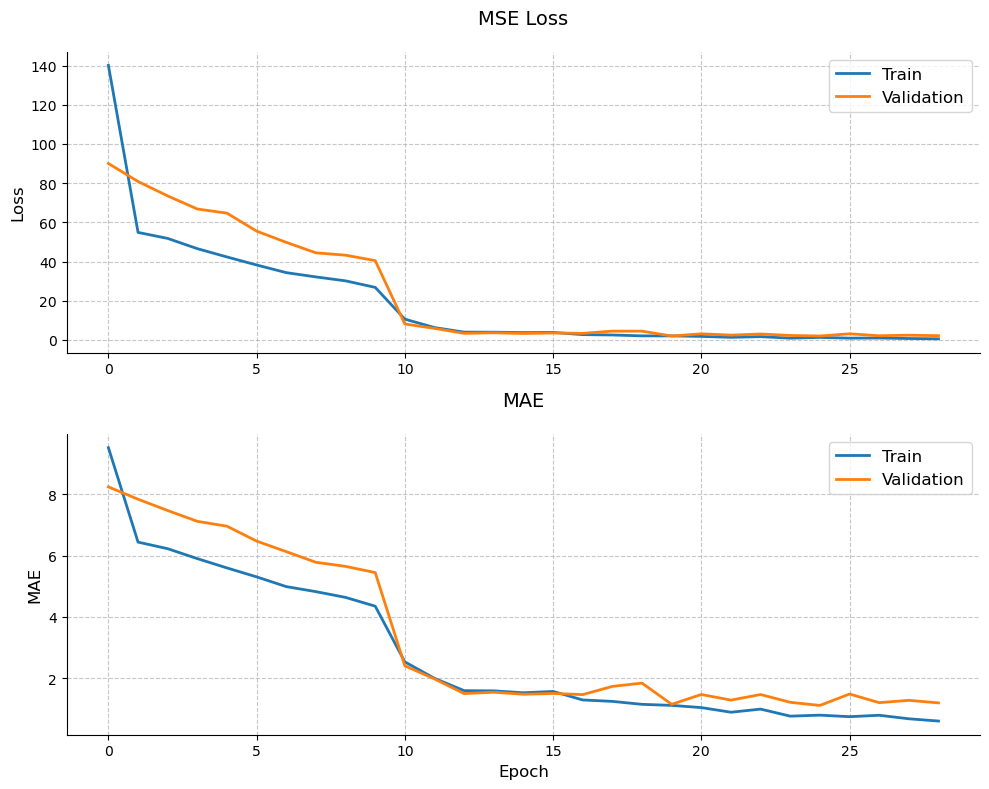

In [120]:
# Plot training and validation process
plot_training_history(train_history_r, val_history_r, metric_name='mae')

In [97]:
# Test Evaluation
def test_regressor(model, test_dataloader, device):
    model.eval()
    predictions = []
    true_values = []
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            
            outputs = model(inputs)
            
            predictions.extend(outputs.cpu().numpy().flatten())
            true_values.extend(labels.cpu().numpy().flatten())
    
    return np.array(predictions), np.array(true_values)

predictions, true_values = test_regressor(model3, test_dataloader, device)

In [124]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

rounded_predictions = np.round(predictions) # rounded predcitons because number of pieces -> integers

mae = mean_absolute_error(true_values, rounded_predictions)
mse = mean_squared_error(true_values, rounded_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(true_values, rounded_predictions)

print(f"**Test Metrics**\n")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


**Test Metrics**

MAE: 1.0817
MSE: 2.0229
RMSE: 1.4223
R²: 0.9706


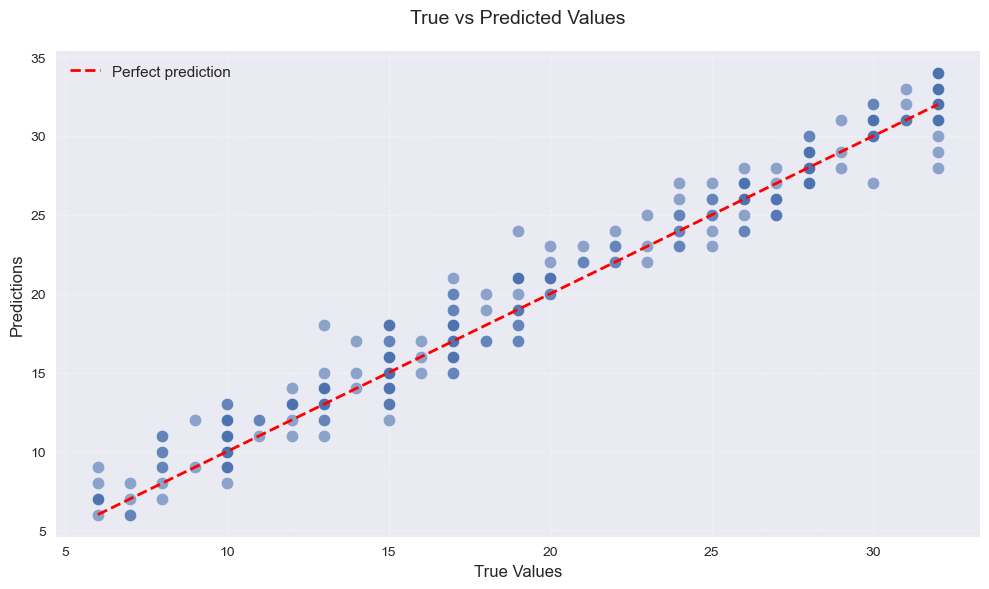

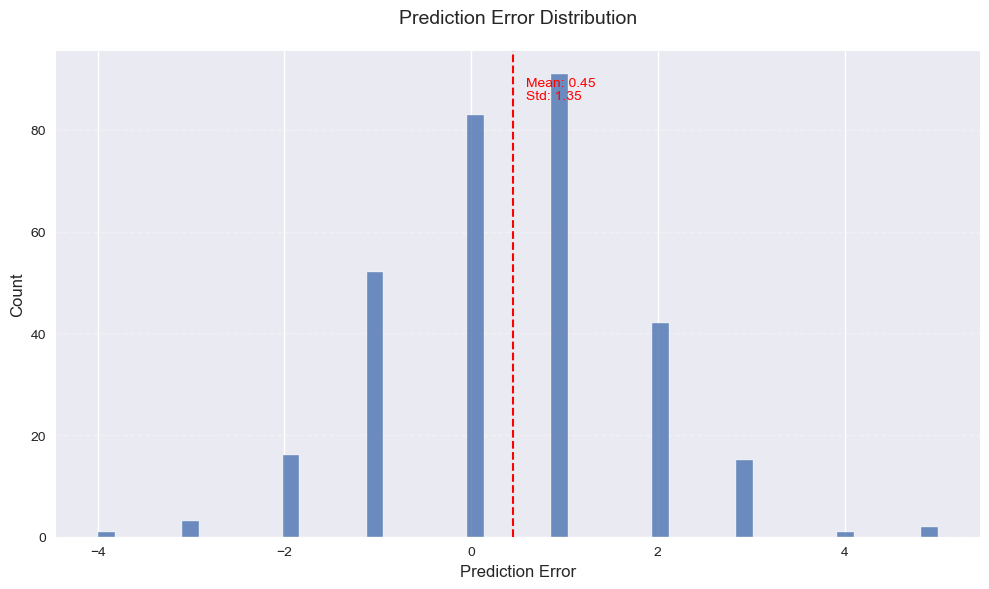

In [127]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8')

# True vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(true_values, rounded_predictions, 
            alpha=0.6,
            edgecolor='w',
            linewidth=0.5,
            s=80)
plt.plot([np.min(true_values), np.max(true_values)], 
         [np.min(true_values), np.max(true_values)], 
         'r--', 
         linewidth=2,
         label='Perfect prediction')
plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predictions', fontsize=12)
plt.title('True vs Predicted Values', fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=11)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# Errors Histogram
errors = rounded_predictions - true_values
plt.figure(figsize=(10, 6))
plt.hist(errors, 
         bins=50, 
         edgecolor='white',
         alpha=0.8)
plt.xlabel('Prediction Error', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Prediction Error Distribution', fontsize=14, pad=20)
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
mean_err = np.mean(errors)
std_err = np.std(errors)
plt.axvline(mean_err, color='r', linestyle='--', linewidth=1.5)
plt.text(mean_err + 0.1*std_err, plt.ylim()[1]*0.9, 
         f'Mean: {mean_err:.2f}\nStd: {std_err:.2f}',
         color='red')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [128]:
# Save model
torch.save(model3, 'model3.pth')

# 3. Squares Occupation Classificator

In [1278]:
# CLAHE
def clahe_image(image, show=False):
    # Convert PIL Image to numpy array if needed
    if isinstance(image, Image.Image):
        img_np = np.array(image)
    else:
        img_np = image.copy()
    
    # CLAHE processing
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    img_contrast = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    # Convert back to PIL Image
    img_pil = Image.fromarray(img_contrast)

    if show:
        fig, axes = plt.subplots(1, 2, figsize=(10, 6))
        axes[0].imshow(image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        axes[1].imshow(img_pil)
        axes[1].set_title('CLAHE')
        axes[1].axis('off')
        plt.show()
    
    return img_pil

# Warp Image Function
def warp_image(image, corners, output_size, use_clahe=False, show=False):
    
    # Convert PIL Image to numpy array if needed
    if isinstance(image, Image.Image):
        img_np = np.array(image)
    else:
        img_np = image.copy()
    
    # Perspective warp
    dst = np.array([
        [0, 0],
        [output_size - 1, 0],
        [output_size - 1, output_size - 1],
        [0, output_size - 1]
    ], dtype='float32')
        
    M = cv2.getPerspectiveTransform(np.array(corners, dtype='float32'), dst)
    warped_image = cv2.warpPerspective(img_np, M, (output_size, output_size))

    # Apply CLAHE
    if use_clahe:
        warped_pil = Image.fromarray(warped_image)
        warped_pil = clahe_image(warped_pil, show=False)
        warped_image = np.array(warped_pil)
        
    # Display the results
    if show:
        fig, axes = plt.subplots(1, 2, figsize=(10, 6))
        axes[0].imshow(image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        axes[1].imshow(warped_image)
        axes[1].set_title('Warped Chessboard')
        axes[1].axis('off')
        plt.show()
        
    return warped_image

In [1279]:
# WARP IMAGES AND SPLIT INTO TRAIN/VAL/TEST
class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, output_size=400):  # Removed transform parameter
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        
        # Load corners data
        self.corners = {}  # Dictionary to store corners for each image
        for corner_data in self.anns['annotations']['corners']:
            self.corners[corner_data['image_id']] = [
                corner_data['corners']['top_left'],
                corner_data['corners']['top_right'],
                corner_data['corners']['bottom_right'],
                corner_data['corners']['bottom_left']
            ]
        
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        
        # Initialize chessboards
        self.boards = torch.zeros((len(self.file_names), 8, 8), dtype=torch.float32)
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1

        # Set split
        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]

        self.output_size = output_size
        print(f"Number of {partition} images: {len(self.file_names)}")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image_path = os.path.join(self.root, self.file_names[i])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get corners for this image
        image_id = self.ids[i]
        corners = self.corners[image_id]
        
        # Warp the image + CLAHE(optional)
        warped_image = warp_image(image, corners, self.output_size, use_clahe=True)
        
        board = self.boards[i]

        return warped_image, board

# Initialize datasets without transform
train_dataset = ChessDataset('', 'train')
valid_dataset = ChessDataset('', 'valid')
test_dataset = ChessDataset('', 'test')

Number of train images: 1442
Number of valid images: 330
Number of test images: 306


Image size: (400, 400, 3)


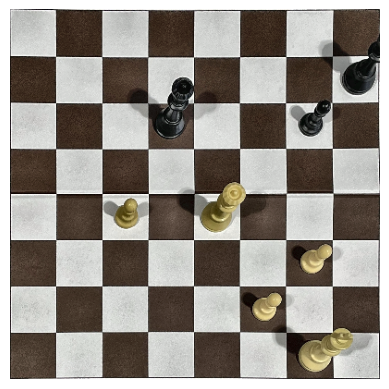

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.]])


In [1369]:
img, labels = train_dataset[107]
# Display an example
print(f'Image size: {img.shape}')
plt.imshow(img)
plt.axis('off')
plt.show()
print(labels)

In [1288]:
# SPLIT CHESSBOARDS INTO SQUARES (8x8) FUNC.
def split_chessboard(warped_image, board_size=8, target_size=48, crop_margin=3):
    
    if len(warped_image.shape) == 2:
        warped_image = np.expand_dims(warped_image, axis=-1)
    
    h, w, c = warped_image.shape
    square_h = h // board_size
    square_w = w // board_size
    
    squares = []
    for row in range(board_size):
        row_squares = []
        for col in range(board_size):
            y1 = row * square_h
            y2 = min(y1 + square_h, h)
            x1 = col * square_w
            x2 = min(x1 + square_w, w)
            
            square = warped_image[y1:y2, x1:x2]
            
            if crop_margin > 0:
                h_crop, w_crop = square.shape[:2]
                square = square[crop_margin:h_crop-crop_margin, crop_margin:w_crop-crop_margin]
            
            if target_size and (square.shape[0] != target_size or square.shape[1] != target_size):
                square = cv2.resize(square, (target_size, target_size))
            
            row_squares.append(square)
        squares.append(row_squares)
    return squares

In [1358]:
# CHESS SQUARES DATASET
class ChessSquareDataset(Dataset):
    def __init__(self, original_dataset, max_samples=None, sample_squares_per_board=8, transform=None):
        self.original_dataset = original_dataset
        self.samples = []  # choosen squares list
        self.sample_squares_per_board = sample_squares_per_board
        self.transform = transform
        
        # Squares target size and crop margin, board size
        self.target_size = 48
        self.crop_margin = 3
        self.board_size = 8
        
        # Classes Balance Control
        self.occupied_count = 0
        self.empty_count = 0
        self.max_ratio = 3  # max difference between occupied and empty squares
        
        for i in range(len(original_dataset)):
            if max_samples and len(self.samples) >= max_samples:
                break
                
            warped_image, board = original_dataset[i]
            
            # Convert to numpy if tensor
            if torch.is_tensor(warped_image):
                warped_image = warped_image.numpy()
            
            # Ensure image is in HWC
            if len(warped_image.shape) == 3 and warped_image.shape[2] > 4:
                warped_image = warped_image.transpose(1, 2, 0)
            
            # Split chessboard
            squares = split_chessboard(
                warped_image,
                board_size=self.board_size,
                target_size=self.target_size,
                crop_margin=self.crop_margin
            )
            # Choose squares randomly keeping classes balance
            self._add_squares(squares, board)

    def _add_squares(self, squares, board):
        occupied_pos = []
        empty_pos = []
        
        for row in range(8):
            for col in range(8):
                if board[row][col] == 1:
                    occupied_pos.append((row, col))
                else:
                    empty_pos.append((row, col))
        
        num_occupied = min(len(occupied_pos), self.sample_squares_per_board // 2)
        selected_occupied = random.sample(occupied_pos, num_occupied) if occupied_pos else []
        
        max_empty = num_occupied * self.max_ratio if num_occupied > 0 else self.sample_squares_per_board
        num_empty = min(len(empty_pos), max_empty, self.sample_squares_per_board - num_occupied)
        selected_empty = random.sample(empty_pos, num_empty) if empty_pos else []
        
        for row, col in selected_occupied + selected_empty:
            square_img = squares[row][col]
            square_img = np.clip(square_img, 0, 255).astype(np.uint8)
            
            self.samples.append((square_img, torch.tensor(board[row][col], dtype=torch.float32)))
            
            if board[row][col] == 1:
                self.occupied_count += 1
            else:
                self.empty_count += 1
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, i):
        square_img, label = self.samples[i]

        if self.transform:
            square_img = self.transform(square_img)
        
        return square_img, label

In [1250]:
# Transform SQUARES with augmentation
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=0.5)
])

# Transform SQUARES without augmentation (just preprocessing)
data_in = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

In [1097]:
# CREATE DATASETS: 10000/2000/2000
train_square_dataset = ChessSquareDataset(
    train_dataset, 
    max_samples=10000,
    sample_squares_per_board=8,  # max 8 squares from the chessboard
    transform=data_aug
)

valid_square_dataset = ChessSquareDataset(
    valid_dataset,
    max_samples=2000,
    sample_squares_per_board=8,
    transform=data_in
)

test_square_dataset = ChessSquareDataset(
    test_dataset,
    max_samples=2000,
    sample_squares_per_board=8,
    transform=data_in
)

/var/folders/r4/8gglhz5x6m12rwlp448hnfnw0000gn/T/ipykernel_30505/2514844865.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.samples.append((square_img, torch.tensor(board[row][col], dtype=torch.float32)))


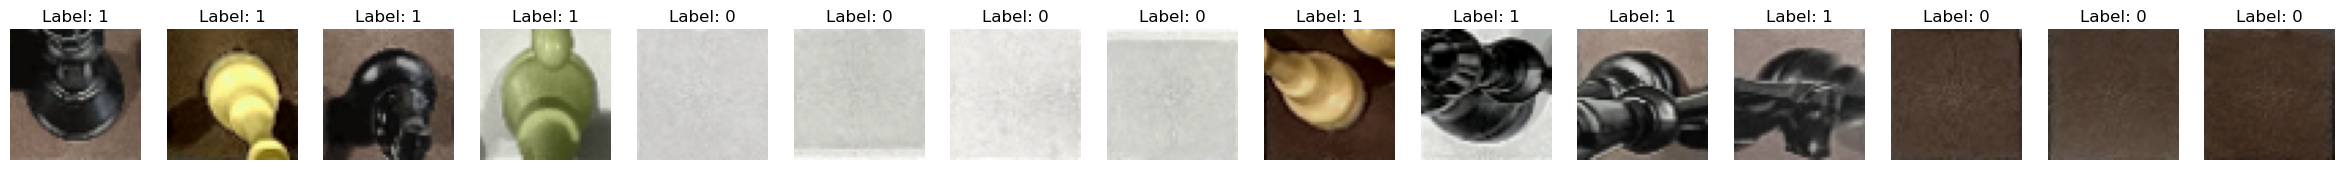

In [1321]:
# Display samples
num_samples=15
fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    
for i in range(num_samples):
    img, label = train_square_dataset[i]
    img_np = img.permute(1, 2, 0).numpy()  # CHW → HWC
    axes[i].imshow(img_np)
    axes[i].set_title(f"Label: {int(label)}")
    axes[i].axis('off')


In [1099]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define a Dataloader (batch inputs, sampling and multiprocess data loading)
batch_size = 64

train_dataloader = DataLoader(train_square_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_square_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_square_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

Using cpu device


In [1100]:
print(f"Number of batches in train loader: {len(train_dataloader)}")
print(f"Number of batches in valid loader: {len(valid_dataloader)}")
print(f"Number of batches in test loader: {len(test_dataloader)}")

Number of batches in train loader: 156
Number of batches in valid loader: 32
Number of batches in test loader: 32


In [1101]:
images, labels = next(iter(train_dataloader))
print(f"Batch shape: {images.shape}")
print(f"Batch labels shape: {labels.shape}")

Batch shape: torch.Size([64, 3, 48, 48])
Batch labels shape: torch.Size([64])


In [1102]:
import torch.nn as nn
import torch.nn.functional as F
# MODEL
class ChessSquareClassifier(nn.Module):
    def __init__(self):
        super(ChessSquareClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 1)
        
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        

        x = x.view(-1, 128 * 6 * 6)
        

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        
        return x
        
# Setup the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model4 = ChessSquareClassifier()
model4

ChessSquareClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [1103]:
# Initialize loss function and optimizer

loss_fn = nn.BCELoss() # Binary Cross Entropy Loss

optimizer = optim.Adam(model4.parameters(), lr=0.001)

In [1104]:
# Train Step
def train_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=10):
   
    model.to(device)

    train_history = {'loss': [], 'acc': []}
    val_history = {'loss': [], 'acc': []}
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        # Validation
        val_loss, val_acc = evaluate_model(model, val_loader, loss_fn, device)

        # History
        train_history['loss'].append(train_loss)
        train_history['acc'].append(train_acc)
        val_history['loss'].append(val_loss)
        val_history['acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    
    return model, train_history, val_history

def evaluate_model(model, loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.unsqueeze(1))
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()
    
    return running_loss / len(loader), correct / total

In [1105]:
model4, train_history, val_history = train_model(
    model4, 
    train_dataloader, 
    valid_dataloader, 
    loss_fn, 
    optimizer, 
    device,
    num_epochs=10
)

Epoch 1/10 [Training]: 100%|██████████████████| 156/156 [00:48<00:00,  3.19it/s]


Epoch 1/10:
Train Loss: 0.1753, Acc: 0.9250
Val Loss: 0.0488, Acc: 0.9845


Epoch 2/10 [Training]: 100%|██████████████████| 156/156 [00:47<00:00,  3.28it/s]


Epoch 2/10:
Train Loss: 0.0651, Acc: 0.9821
Val Loss: 0.0389, Acc: 0.9910


Epoch 3/10 [Training]: 100%|██████████████████| 156/156 [00:46<00:00,  3.34it/s]


Epoch 3/10:
Train Loss: 0.0396, Acc: 0.9876
Val Loss: 0.0249, Acc: 0.9940


Epoch 4/10 [Training]: 100%|██████████████████| 156/156 [00:46<00:00,  3.37it/s]


Epoch 4/10:
Train Loss: 0.0247, Acc: 0.9922
Val Loss: 0.0263, Acc: 0.9940


Epoch 5/10 [Training]: 100%|██████████████████| 156/156 [00:47<00:00,  3.31it/s]


Epoch 5/10:
Train Loss: 0.0223, Acc: 0.9929
Val Loss: 0.0291, Acc: 0.9915


Epoch 6/10 [Training]: 100%|██████████████████| 156/156 [00:46<00:00,  3.37it/s]


Epoch 6/10:
Train Loss: 0.0175, Acc: 0.9941
Val Loss: 0.0177, Acc: 0.9955


Epoch 7/10 [Training]: 100%|██████████████████| 156/156 [00:47<00:00,  3.27it/s]


Epoch 7/10:
Train Loss: 0.0215, Acc: 0.9919
Val Loss: 0.0249, Acc: 0.9925


Epoch 8/10 [Training]: 100%|██████████████████| 156/156 [00:46<00:00,  3.32it/s]


Epoch 8/10:
Train Loss: 0.0126, Acc: 0.9963
Val Loss: 0.0180, Acc: 0.9955


Epoch 9/10 [Training]: 100%|██████████████████| 156/156 [00:47<00:00,  3.30it/s]


Epoch 9/10:
Train Loss: 0.0108, Acc: 0.9956
Val Loss: 0.0177, Acc: 0.9970


Epoch 10/10 [Training]: 100%|█████████████████| 156/156 [00:47<00:00,  3.32it/s]


Epoch 10/10:
Train Loss: 0.0085, Acc: 0.9972
Val Loss: 0.0234, Acc: 0.9910


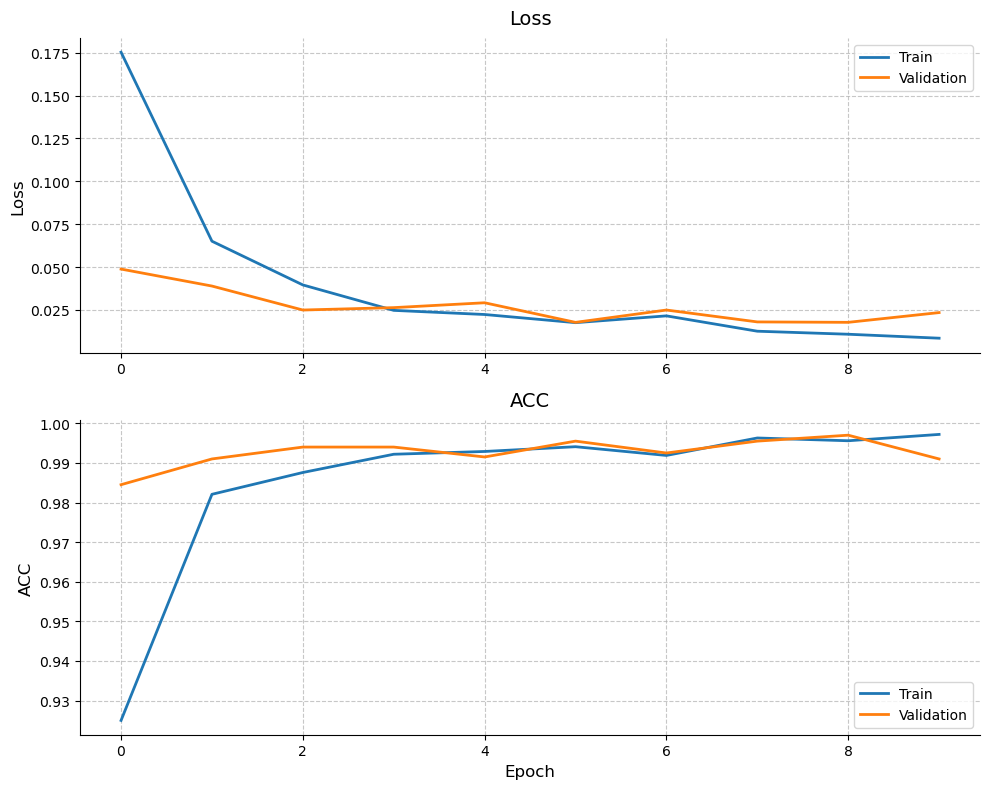

In [1106]:
# Display training and validation history
plot_training_history(train_history, val_history,  loss_name='Loss', metric_name='acc')

In [1107]:
from sklearn.metrics import (
    confusion_matrix, f1_score, accuracy_score,
    precision_score, recall_score, classification_report
)
import seaborn as sns

# Evaluate Model
def evaluate_model_metrics(model, test_loader, device, class_names=['NEG','POS']):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    
    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    
    # Classification report
    report = classification_report(
        all_labels,
        all_preds,
        target_names=class_names
    )
    
    # Confusion matrix plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names or ['Pred 0', 'Pred 1'],
                yticklabels=class_names or ['True 0', 'True 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nClassification Report:\n")
    print(report)
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': all_preds,
        'true_labels': all_labels
    }


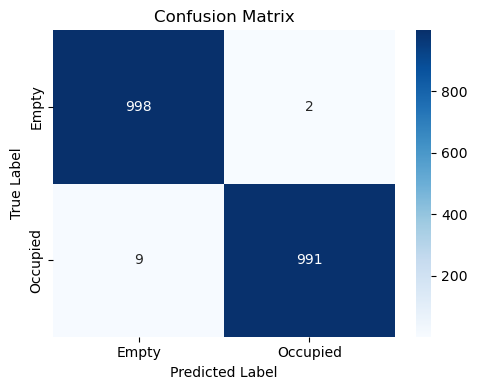

Accuracy: 0.9945
F1 Score: 0.9945
Precision: 0.9980
Recall: 0.9910

Classification Report:

              precision    recall  f1-score   support

       Empty       0.99      1.00      0.99      1000
    Occupied       1.00      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [1108]:
# Metrics
metrics = evaluate_model_metrics(model4, test_dataloader, device, class_names=['Empty', 'Occupied'])

In [1386]:
# Number of pieces prediction for a single image
def count_pieces_predictions(model, image, label_matrix, display=False):

    board_size=8
    squares = split_chessboard(image, board_size, target_size=48, crop_margin=3)
    model.eval()
    predictions = []
    true_labels = []

    for row in range(board_size):
        for col in range(board_size):
            square = squares[row][col]  # (H, W, 3)
            input_tensor = torch.tensor(square).permute(2, 0, 1).unsqueeze(0).float() / 255.0

            with torch.no_grad():
                output = model(input_tensor)

            pred_label = int(output.item() > 0.5)
            true_label = int(label_matrix[row][col])

            predictions.append(pred_label)
            true_labels.append(true_label)

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    accuracy = np.mean(predictions == true_labels)
    predicted_pawns = np.sum(predictions)
    actual_pawns = np.sum(true_labels)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Num of detected pieces: {predicted_pawns}")
    print(f"Num of real pieces: {actual_pawns}")

    if display:
        plt.imshow(image)
        plt.axis('off')
        plt.title('Sample from test_dataset')
        plt.show()
    return {
        'accuracy': accuracy,
        'predicted_pawns': int(predicted_pawns),
        'actual_pawns': int(actual_pawns),
        'errors': [(i // board_size, i % board_size) for i, (p, t) in enumerate(zip(predictions, true_labels)) if p != t]
    }

Accuracy: 98.44%
Num of detected pieces: 31
Num of real pieces: 32


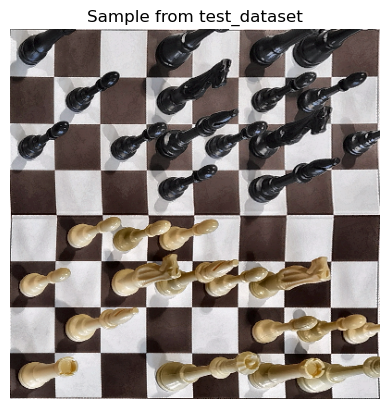

In [1387]:
image, label_matrix = test_dataset[21]
results = count_pieces_predictions(model4, image, label_matrix, display=True)

In [1332]:
# Save model
torch.save(model4, 'model4.pth')

In [1356]:
# Evaluate model globally for test_dataset
def evaluate_pieces_count(model, dataset):
    
    model.eval()
    results = {
        'total_chessboards': len(dataset),
        'accuracy': 0.0,
        'mae': 0.0,
        'relative_error': 0.0,
        'per_image_results': []
    }

    mae_errors = []
    relative_errors = []
    correct = 0

    board_size=8
    
    for idx in range(len(dataset)):
        image, label_matrix = dataset[idx]
        
        if torch.is_tensor(image):
            image = image.numpy().transpose(1, 2, 0)
        
        squares = split_chessboard(image, board_size, target_size=48, crop_margin=3) # get squares
        
        predicted_pawns = 0
        actual_pawns = int(label_matrix.sum().item())
        
        for row in range(board_size):
            for col in range(board_size):
                square = squares[row][col]
                
                input_tensor = torch.tensor(square).permute(2, 0, 1).unsqueeze(0).float() / 255.0 # normalize to [0,1]
                input_tensor = input_tensor.to(device)
                
                with torch.no_grad():
                    output = model(input_tensor)
                    pred = int(output.item() > 0.5)
                    predicted_pawns += pred
                    
        error = abs(predicted_pawns - actual_pawns)
        rel_error = error / actual_pawns if actual_pawns != 0 else 0.0
        
        mae_errors.append(error)
        relative_errors.append(rel_error)
        
        if error == 0:
            correct += 1
        
        results['per_image_results'].append({
            'chessboard_idx': idx,
            'actual_pawns': actual_pawns,
            'predicted_pawns': predicted_pawns,
            'error': error,
            'relative_error': rel_error
        })

    # Global Metrics
    results['accuracy'] = correct / len(dataset)
    results['mae'] = sum(mae_errors) / len(mae_errors)
    results['relative_error'] = sum(relative_errors) / len(relative_errors) * 100

    return results

In [1362]:
report = evaluate_pieces_count(model4, test_dataset)

In [1414]:
print('Global Metrics (testset):\n')
print(f"Accuracy: {report['accuracy']:.2%}")
print(f"Mean Absolute Error (MAE): {report['mae']:.2f}")
print(f"Mean Relative Error: {report['relative_error']:.2f}%")
errors = [img_result['error'] for img_result in report['per_image_results']]
print(f"Max error: {max(errors)}")

Global Metrics (testset):

Accuracy: 68.95%
Mean Absolute Error (MAE): 0.37
Mean Relative Error: 1.97%
Max error: 4


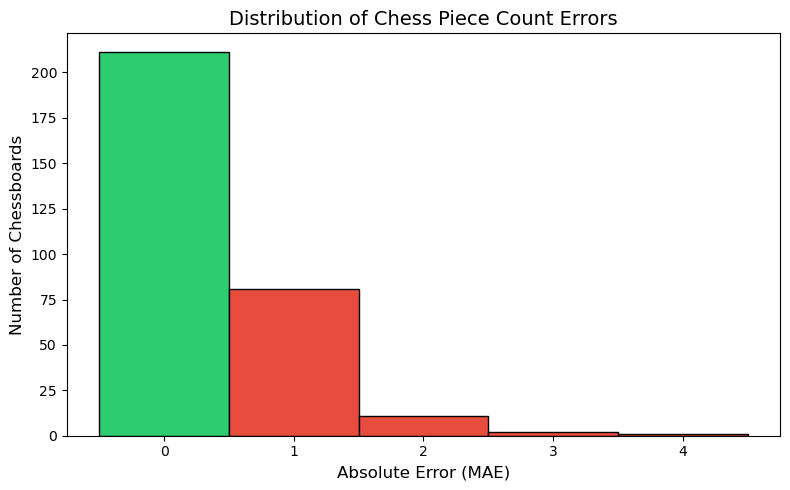

In [1413]:
import matplotlib.pyplot as plt
import numpy as np

bins = np.arange(-0.5, max(errors) + 1.5, 1)
counts, _ = np.histogram(errors, bins=bins)

plt.figure(figsize=(8, 5))
for i in range(len(bins) - 1):
    color = '#2ecc71' if bins[i] < 0.5 else '#e74c3c'
    plt.bar(bins[i] + 0.5, counts[i], width=1, color=color, edgecolor='black')

plt.xticks(np.arange(0, max(errors) + 1))
plt.xlabel('Absolute Error (MAE)', fontsize=12)
plt.ylabel('Number of Chessboards', fontsize=12)
plt.title('Distribution of Chess Piece Count Errors', fontsize=14)

plt.tight_layout()
plt.show()